# VAE

In [108]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )

from FIA import *
from ML4com import *

import keras
from keras.layers import Input, Dense, Lambda
from keras.layers import BatchNormalization, Dropout, LeakyReLU
from keras.models import Model
from keras.losses import mse
from keras.optimizers.legacy import Adam, Nadam     # Nadam should converge smaller
from keras import activations, layers
from keras import backend as K

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import keras_tuner
from keras_tuner.tuners import Hyperband, BayesianOptimization

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
info_dir = "../../data/comm8_self"
data_dir = "../../runs/FIA/comm8/oms"
run_dir = "../../runs/ML/try"

info_dir = os.path.normpath(os.path.join(os.getcwd(), info_dir))
data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

strains = pd.read_csv(os.path.join(info_dir, "strains.tsv"), sep="\t")
comm8 = pd.read_csv(os.path.join(info_dir, "comm8.tsv"), sep="\t")

fia_df = load_fia_df(data_dir, file_ending=".mzML", separator="\t")

Loading names:


100%|██████████| 72/72 [00:00<?, ?it/s]


Loading experiments:


  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:03<00:00, 22.42it/s]


In [3]:
# binned_dfs = bin_df_stepwise_batch(fia_df, binning_var="mz", binned_var="inty", statistic="sum", start=50.0, stop=1700.0, step=0.002)
# binned_dfs.to_csv(os.path.join(run_dir, "data_matrix.tsv"), sep="\t")
binned_dfs = pd.read_csv(os.path.join(run_dir, "data_matrix_oms.tsv"), sep="\t", index_col="mz", engine="pyarrow")

In [4]:
def total_ion_count_normalization(df):
    return df / df.sum()

In [5]:
binned_dfs[:] =  total_ion_count_normalization(binned_dfs)

In [6]:
print(binned_dfs.shape)
print(comm8.shape)
print(strains.shape)

(825000, 68)
(68, 8)
(8, 1)


In [7]:
# Data & model configuration
batch_size = 32
no_epochs = 1000
latent_dim = 18

original_dim = binned_dfs.shape[0]
input_shape = (original_dim,)

## Model

In [8]:
def model_builder(hp):
    # # =================
    # # Encoder
    # # =================

    # Definition
    i       = Input(shape=input_shape, name='encoder_input')
    
    x       = Dense(hp.Int('encoder_units', min_value=20, max_value=200, step=40))(i)
    x       = LeakyReLU()(x)
    
    mu      = Dense(latent_dim, name='latent_mu')(x)
    sigma   = Dense(latent_dim, name='latent_sigma')(x)

    # Define sampling with reparameterization trick
    def sample_z(args):
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps

    # Use reparameterization trick
    z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

    # Instantiate encoder
    encoder = Model(i, [mu, sigma, z], name='encoder')
    
    # =================
    # Decoder
    # =================

    # Definition
    d_i   = Input(shape=(latent_dim, ), name='decoder_input')
    
    x     = Dense(hp.Int('decoder_units', min_value=20, max_value=200, step=40))(d_i)
    x     = LeakyReLU()(x)
        
    o     = Dense(original_dim)(x)

    # Instantiate decoder
    decoder = Model(d_i, o, name='decoder')
    
    # =================
    # VAE as a whole
    # =================

    # Define loss
    def kl_reconstruction_loss(true, pred):
      # Reconstruction loss
        reconstruction_loss = mse(true, pred)
        reconstruction_loss *= original_dim

        # KL divergence loss
        kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        # weight KL divergence loss here
        kl_loss *= hp.Float('kl_beta', min_value=1e-3, max_value=1e1, sampling='LOG', default=1e-2)

        return K.mean(reconstruction_loss + kl_loss)

    # Instantiate VAE
    vae_outputs = decoder(encoder(i)[2])
    vae         = Model(i, vae_outputs, name='vae')

    # Define optimizer
    optimizer = Nadam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))

    # Compile VAE
    vae.compile(optimizer=optimizer, loss=kl_reconstruction_loss, metrics = ['mse'], experimental_run_tf_function=False)
    
    return vae

In [9]:
# Set tuner parameters
tuner = Hyperband(
    model_builder,
    objective='mse',
    factor=2,
    max_epochs=50,
    directory='../../runs/VAE/hyperband_optimization',
    project_name='mtvae_nadam_thight_search')

Reloading Tuner from ../../runs/VAE/hyperband_optimization\mtvae_nadam_thight_search\tuner0.json


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
encoder_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 40, 'sampling': 'linear'}
decoder_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 200, 'step': 40, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
kl_beta (Float)
{'default': 0.01, 'conditions': [], 'min_value': 0.001, 'max_value': 10.0, 'step': None, 'sampling': 'log'}


In [11]:
X = binned_dfs.transpose()
ys = comm8
kf = KFold(n_splits = 5, shuffle=True)     # stratified: skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

training_data, test_data, training_labels, test_labels = train_test_split(X, ys, test_size=0.2, random_state=42)

In [12]:
# tuner.search(training_data, training_data, validation_data = (test_data, test_data))          # ~2h runtime

## Return best

In [13]:
tuner.results_summary(num_trials = 1)

Results summary
Results in ../../runs/VAE/hyperband_optimization\mtvae_nadam_thight_search
Showing 1 best trials
Objective(name="mse", direction="min")

Trial 0174 summary
Hyperparameters:
encoder_units: 180
decoder_units: 20
learning_rate: 0.001282973471073738
kl_beta: 0.00542722971087829
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 9.425958680253643e-09


In [14]:
tuner.get_best_models()[0].summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 825000)]          0         
                                                                 
 encoder (Functional)        [(None, 18),              148506696 
                              (None, 18),                        
                              (None, 18)]                        
                                                                 
 decoder (Functional)        (None, 825000)            17325380  
                                                                 
Total params: 165832076 (632.60 MB)
Trainable params: 165832076 (632.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [16]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(best_hps.get('encoder_units'))
print(best_hps.get('decoder_units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('kl_beta'))

180
20
0.001282973471073738
0.00542722971087829


## Training

In [17]:
sys.path.append( '../../../mtVAE' )
from models import *
from metric_functions import *

In [18]:
# Data & model configuration
input_dim = original_dim
intermediate_dim = 200
latent_dim = 20

kl_beta = 5e-3
learning_rate = 1e-3

batch_size = 32
n_epochs = 1000

save_folder = '../../runs/VAE'


# instantiate model
mtmodel = mtVAE(input_dim, intermediate_dim, latent_dim, kl_beta, learning_rate)

In [19]:
# Train model
history = mtmodel.train(training_data, test_data, n_epochs, batch_size)       # Changes: Nadam optimizer


Train on 54 samples, validate on 14 samples
Epoch 1/1000
54/54 - 3s - loss: 74.7452 - mse: 9.0600e-05 - val_loss: 105.2058 - val_mse: 1.2752e-04 - 3s/epoch - 57ms/sample
Epoch 2/1000


c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54/54 - 3s - loss: 86.5906 - mse: 1.0496e-04 - val_loss: 49.9344 - val_mse: 6.0527e-05 - 3s/epoch - 51ms/sample
Epoch 3/1000
54/54 - 3s - loss: 40.2921 - mse: 4.8839e-05 - val_loss: 21.7059 - val_mse: 2.6310e-05 - 3s/epoch - 51ms/sample
Epoch 4/1000
54/54 - 3s - loss: 14.8338 - mse: 1.7980e-05 - val_loss: 10.5519 - val_mse: 1.2790e-05 - 3s/epoch - 51ms/sample
Epoch 5/1000
54/54 - 3s - loss: 11.9509 - mse: 1.4486e-05 - val_loss: 24.8016 - val_mse: 3.0062e-05 - 3s/epoch - 51ms/sample
Epoch 6/1000
54/54 - 3s - loss: 12.9291 - mse: 1.5672e-05 - val_loss: 21.9757 - val_mse: 2.6637e-05 - 3s/epoch - 51ms/sample
Epoch 7/1000
54/54 - 3s - loss: 19.8048 - mse: 2.4006e-05 - val_loss: 28.8158 - val_mse: 3.4928e-05 - 3s/epoch - 51ms/sample
Epoch 8/1000
54/54 - 3s - loss: 37.0287 - mse: 4.4883e-05 - val_loss: 20.1418 - val_mse: 2.4414e-05 - 3s/epoch - 51ms/sample
Epoch 9/1000
54/54 - 3s - loss: 25.3141 - mse: 3.0684e-05 - val_loss: 17.2291 - val_mse: 2.0884e-05 - 3s/epoch - 53ms/sample
Epoch 10/1000

In [20]:
# Save model
mtmodel.save_model(save_folder)

c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
reconstructed_data = mtmodel.reconstruct(test_data)

In [70]:
plot_df = pd.DataFrame(reconstructed_data.clip(min=0)[0], index=binned_dfs.index, columns=["inty"]).reset_index()
plot_df

,mz,inty
0,50.001,0.000000
1,50.003,0.000000
2,50.005,0.000011
3,50.007,0.000000
4,50.009,0.000044
...,...,...
824995,1699.991,0.000018
824996,1699.993,0.000000
824997,1699.995,0.000000
824998,1699.997,0.000000


In [71]:
plot_df_2 = pd.DataFrame(test_data.iloc[0].values, index=binned_dfs.index, columns=["inty"]).reset_index()
plot_df_2

,mz,inty
0,50.001,0.0
1,50.003,0.0
2,50.005,0.0
3,50.007,0.0
4,50.009,0.0
...,...,...
824995,1699.991,0.0
824996,1699.993,0.0
824997,1699.995,0.0
824998,1699.997,0.0


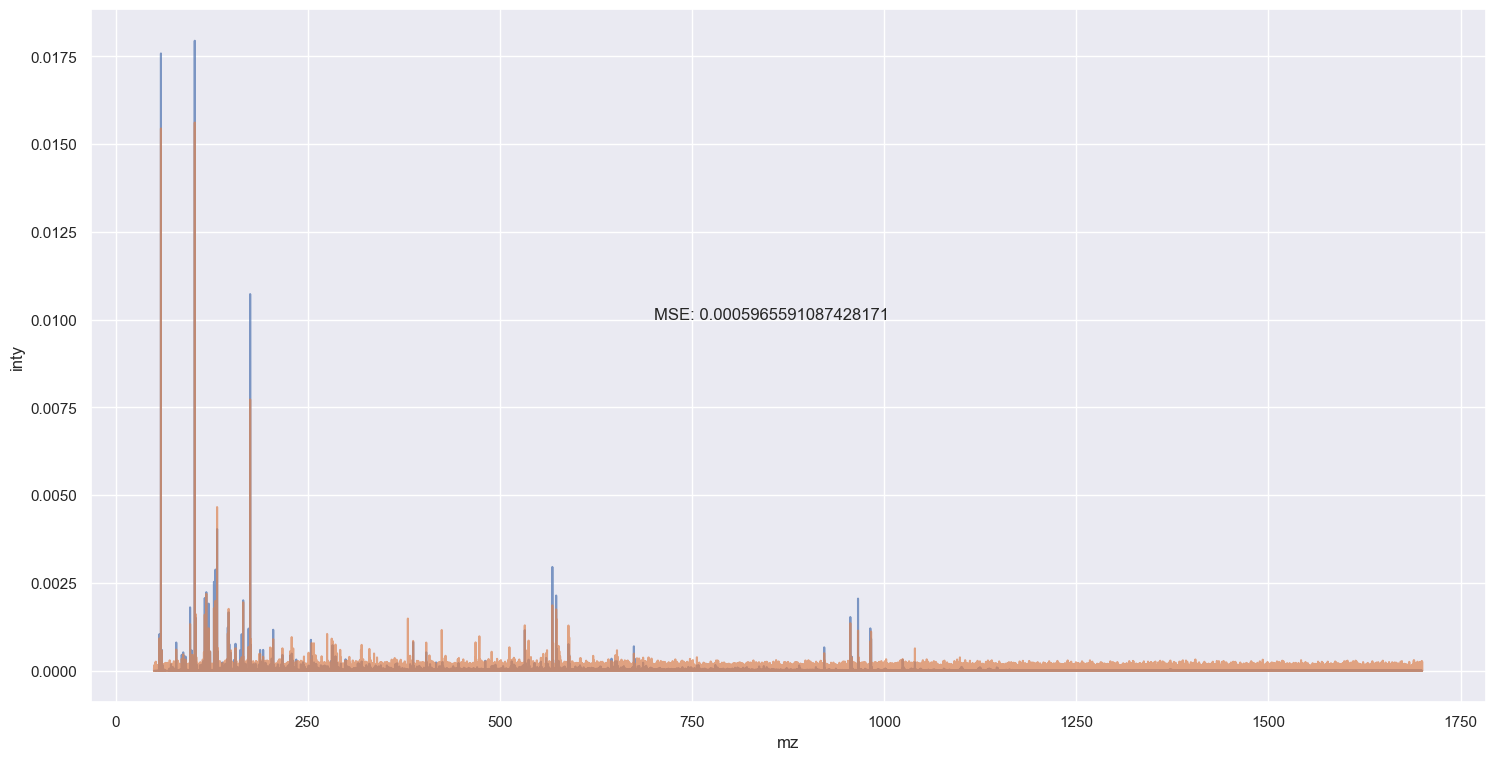

In [72]:
mse = np.mean(np.sum((plot_df_2["inty"] - plot_df["inty"])**2))
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty", alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
plt.text(700, 0.01, f"MSE: {mse}")
plt.show()

(-0.0001, 0.003)

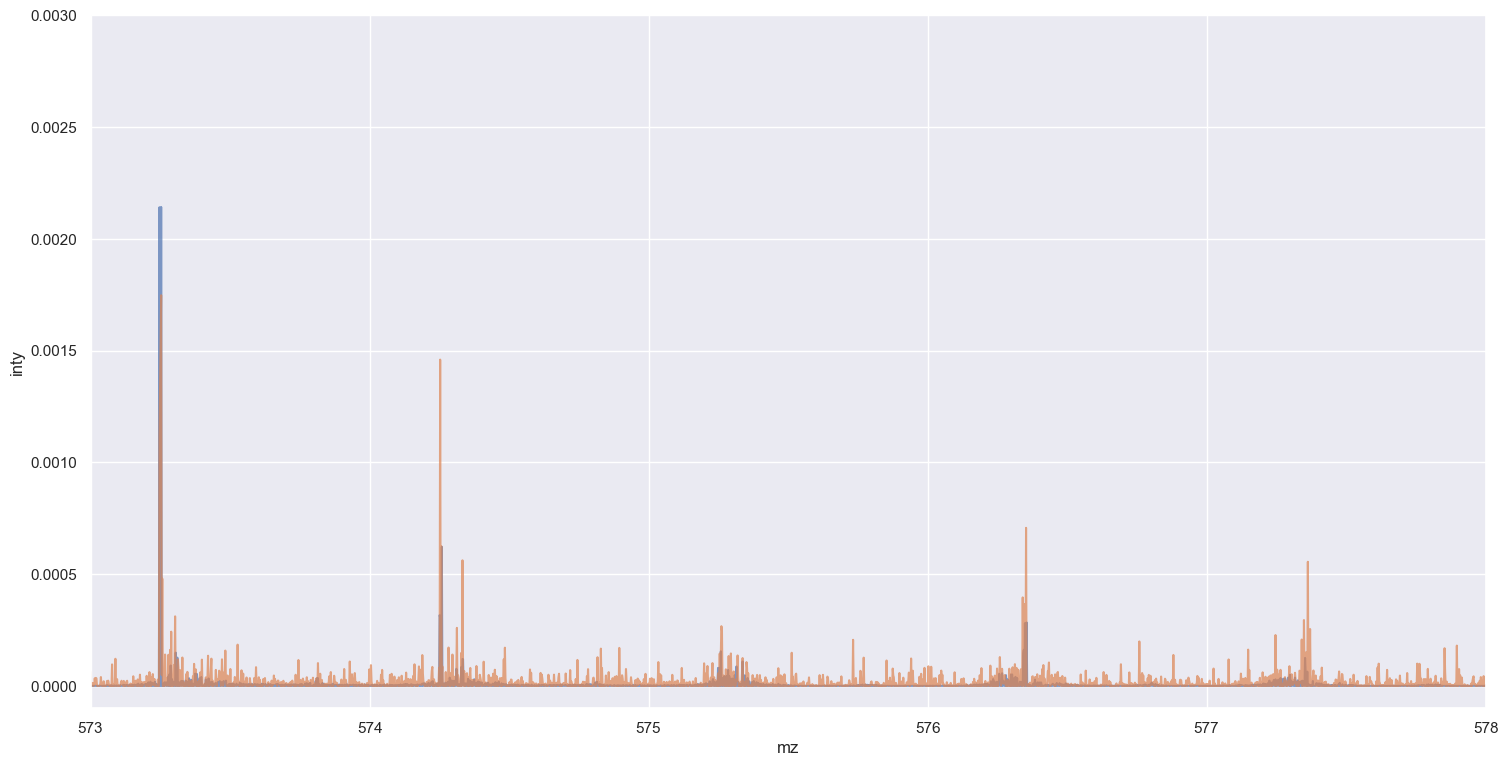

In [75]:
sns.set(rc={"figure.figsize":(18, 9)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573, 578)
ax.set_ylim(-0.0001, 0.003)

(-0.0001, 0.0022)

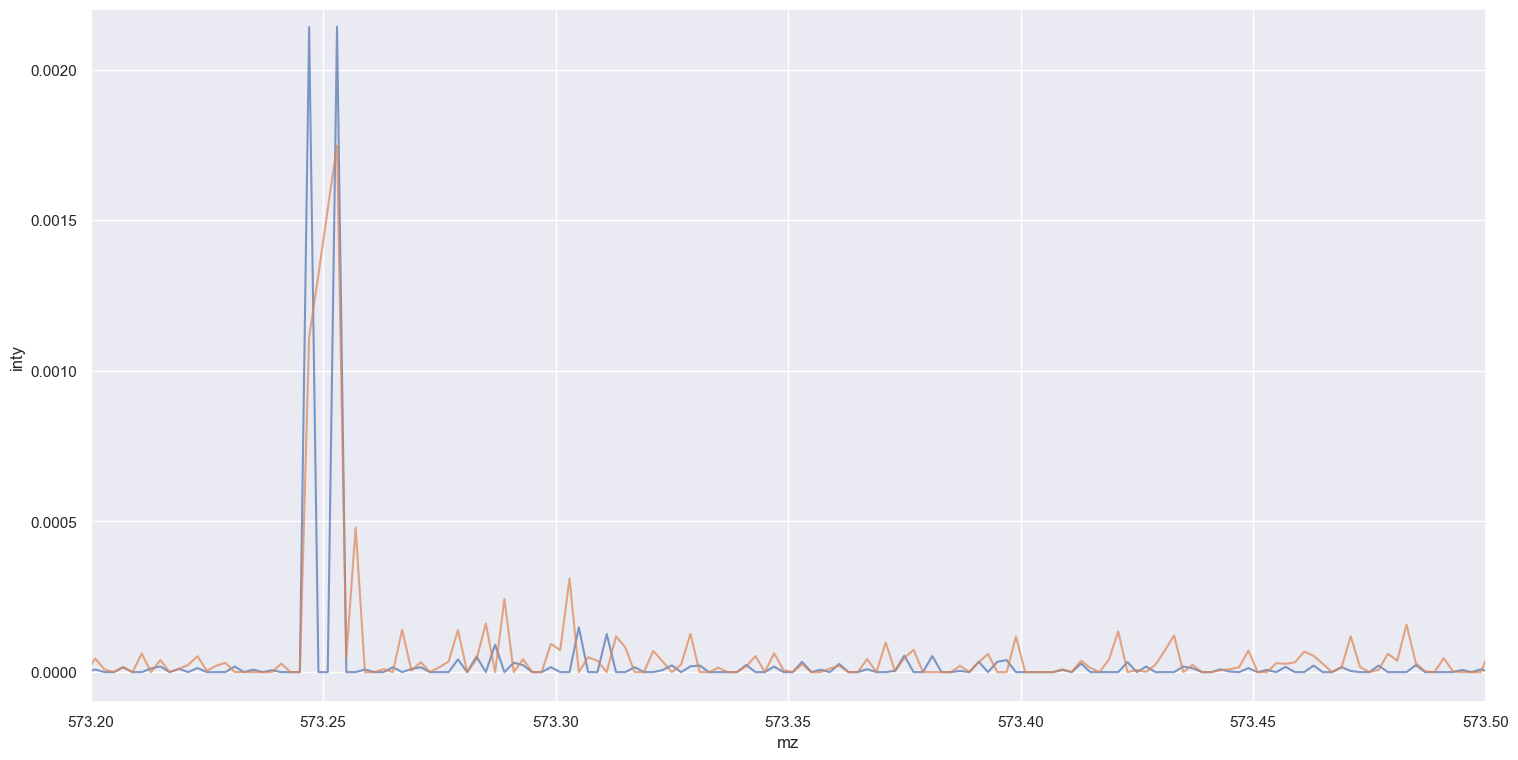

In [78]:
sns.set(rc={"figure.figsize":(18, 9)})
ax = sns.lineplot(data=plot_df_2, x="mz", y="inty" ,alpha=0.7)
ax = sns.lineplot(data=plot_df, x="mz", y="inty", alpha=0.7)
ax.set_xlim(573.2, 573.5)
ax.set_ylim(-0.0001, 0.0022)

## Classification

In [98]:
# Load matrices
strains = pd.read_csv("../../data/comm8_0/strains.tsv", sep="\t")
comm8 = pd.read_csv("../../data/comm8_0/comm8.tsv", sep="\t")

In [104]:
vae_enc = mtmodel.encode_mu(X)
vae_enc = pd.DataFrame(vae_enc)
vae_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.072547,0.193706,-0.246984,0.103078,-0.034055,0.087197,0.332696,-0.031756,-0.008434,-0.182384,0.084124,0.115049,0.046947,-0.141226,0.056187,0.038929,0.100577,-0.059534,-0.145672,-0.345593
1,0.073994,0.192558,-0.250406,0.103800,-0.033327,0.087426,0.333318,-0.032508,-0.009221,-0.182978,0.086673,0.115540,0.046264,-0.142333,0.055928,0.037546,0.102279,-0.058405,-0.144383,-0.346799
2,0.072759,0.192273,-0.246644,0.104706,-0.033254,0.088042,0.329254,-0.031353,-0.008261,-0.184193,0.083355,0.114546,0.045542,-0.141848,0.054722,0.039553,0.100435,-0.059297,-0.144387,-0.344849
3,0.073676,0.193536,-0.246298,0.104046,-0.035569,0.087271,0.332799,-0.032652,-0.008175,-0.181848,0.083656,0.114861,0.047093,-0.141284,0.056264,0.037502,0.101808,-0.060081,-0.145792,-0.345335
4,0.072629,0.192915,-0.246532,0.102966,-0.034022,0.087109,0.332011,-0.031792,-0.008293,-0.182258,0.083954,0.114565,0.046666,-0.140999,0.056120,0.038917,0.100393,-0.059518,-0.145412,-0.344657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.073747,0.194946,-0.248619,0.105027,-0.035329,0.088676,0.334446,-0.032393,-0.007746,-0.183765,0.085365,0.114499,0.046861,-0.142416,0.057028,0.040802,0.101493,-0.059483,-0.145956,-0.347044
64,0.071151,0.192432,-0.245052,0.102671,-0.033887,0.086207,0.330413,-0.031605,-0.007164,-0.183159,0.082858,0.114294,0.046052,-0.139011,0.055819,0.036427,0.099529,-0.059241,-0.146106,-0.342930
65,0.072522,0.193103,-0.246419,0.103044,-0.033954,0.087066,0.331960,-0.031810,-0.008342,-0.182268,0.083932,0.114564,0.046697,-0.140873,0.056079,0.038855,0.100332,-0.059486,-0.145365,-0.344617
66,0.074601,0.192810,-0.249542,0.104194,-0.033502,0.088400,0.334785,-0.031462,-0.008047,-0.183943,0.084397,0.114833,0.047851,-0.143207,0.055697,0.039131,0.102458,-0.061119,-0.146865,-0.347688


In [120]:
from sklearn.model_selection import KFold
X = vae_enc
ys = comm8
kf = KFold(n_splits = 5, shuffle=True)

In [147]:
def build_model(hyperparameters):
    model = keras.Sequential(name="MS_community_classifier")
    if hyperparameters.Boolean("dropout_in"):
        model.add(keras.layers.Dropout(0.1, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())
    
    for i in range(hyperparameters.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hyperparameters.Int(f"units_{i}", min_value=32, max_value=256, step=64),
                activation=hyperparameters.Choice("activation", ["relu", "tanh"]),
            )
        )    
    if hyperparameters.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.25, noise_shape=None, seed=None))
    model.add(keras.layers.BatchNormalization())

    model.add(layers.Dense(1,  activation=activations.sigmoid))
    
    loss_function = keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0.0, axis=-1, reduction="sum_over_batch_size", name="binary_crossentropy")

    learning_rate = hyperparameters.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    return model

In [148]:
hp = keras_tuner.HyperParameters()
hp.Fixed("dropout", True)
hp.Fixed("num_layers", 1)
hp.Fixed("units_1", 10)
hp.Fixed("activation", "relu")
hp.Fixed("lr", 1e-3)
model = build_model(hp)

In [150]:
confusion_matrices = []
accuracies = []

for y in tqdm(ys.columns):
	y = ys[y]
	conf_mats = []
	acc = []
	for train_index, val_index in kf.split(X, y):
		training_data = X.iloc[train_index]
		training_labels = y.iloc[train_index]
		validation_data = X.iloc[val_index]
		validation_labels = y.iloc[val_index]
		
		callback = keras.callbacks.EarlyStopping(monitor='loss', patience=1000)	# Model will stop when no improvment is reached after 1000 epochs
		history = model.fit(training_data, training_labels, epochs=10000, verbose=0, callbacks=[callback])

		val_loss, val_acc = model.evaluate(validation_data,  validation_labels, verbose="auto")
		acc.append(val_acc)
		prediction = model.predict(validation_data)
		prediction = [0.0 if pred[0] < 0.5 else 1.0 for pred in prediction]
		conf_mats.append(confusion_matrix(validation_labels,  prediction))
	
	accuracies.append(np.mean(acc))
	confusion_matrices.append(np.sum(conf_mats, axis=0))

  0%|          | 0/8 [00:00<?, ?it/s]


ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=          0         1         2         3         4         5         6   \
0   0.072547  0.193706 -0.246984  0.103078 -0.034055  0.087197  0.332696   
2   0.072759  0.192273 -0.246644  0.104706 -0.033254  0.088042  0.329254   
3   0.073676  0.193536 -0.246298  0.104046 -0.035569  0.087271  0.332799   
4   0.072629  0.192915 -0.246532  0.102966 -0.034022  0.087109  0.332011   
5   0.072570  0.193400 -0.246720  0.103051 -0.033989  0.087185  0.332299   
6   0.072029  0.192933 -0.246516  0.105305 -0.034288  0.087575  0.331834   
7   0.072869  0.197602 -0.248079  0.103243 -0.034712  0.087364  0.334283   
11  0.072994  0.195545 -0.245256  0.100683 -0.033444  0.087591  0.332493   
12  0.072735  0.195199 -0.248473  0.103281 -0.034149  0.087640  0.334971   
15  0.072065  0.195419 -0.246250  0.099754 -0.033719  0.085358  0.329615   
16  0.072643  0.193983 -0.247474  0.103008 -0.034189  0.087207  0.333317   
17  0.073819  0.194173 -0.248009  0.104500 -0.034229  0.088387  0.336856   
19  0.073960  0.193355 -0.246562  0.103874 -0.032637  0.087585  0.335019   
21  0.072105  0.195837 -0.246369  0.102059 -0.035837  0.085449  0.333595   
22  0.074068  0.193917 -0.247780  0.102906 -0.033763  0.087245  0.333475   
23  0.073347  0.193712 -0.245138  0.103975 -0.033648  0.087928  0.332032   
24  0.073084  0.192329 -0.242841  0.102191 -0.033261  0.085690  0.326777   
25  0.072566  0.192739 -0.246190  0.102947 -0.033968  0.086952  0.331469   
26  0.072017  0.190698 -0.245107  0.104715 -0.032885  0.088539  0.330059   
27  0.071730  0.192490 -0.248320  0.104557 -0.034072  0.087037  0.334234   
28  0.072602  0.193396 -0.246836  0.103067 -0.034066  0.087192  0.332468   
29  0.073668  0.196357 -0.250439  0.103416 -0.033777  0.088730  0.338075   
30  0.071795  0.194082 -0.247864  0.102738 -0.034129  0.087395  0.333288   
31  0.072128  0.193017 -0.246183  0.102917 -0.033512  0.086427  0.332361   
32  0.073411  0.192673 -0.246783  0.103301 -0.033653  0.085528  0.331543   
34  0.073099  0.193762 -0.245985  0.101249 -0.033919  0.085402  0.332525   
35  0.072981  0.193295 -0.245518  0.102668 -0.035018  0.086067  0.331425   
36  0.072484  0.194476 -0.247018  0.104672 -0.034594  0.087728  0.331173   
37  0.073332  0.192464 -0.245079  0.102335 -0.034873  0.087190  0.334501   
38  0.073158  0.193512 -0.245968  0.104941 -0.034917  0.087637  0.331492   
39  0.068801  0.193149 -0.244565  0.103774 -0.035980  0.086256  0.328942   
40  0.073028  0.194366 -0.248004  0.104838 -0.035613  0.087056  0.334597   
41  0.072497  0.191677 -0.245217  0.102791 -0.033890  0.086684  0.329979   
42  0.074263  0.191520 -0.248229  0.102856 -0.034898  0.085769  0.331082   
43  0.073253  0.190797 -0.248234  0.101140 -0.034668  0.086032  0.328885   
44  0.073369  0.192714 -0.248429  0.102718 -0.035390  0.087758  0.332985   
45  0.072060  0.190041 -0.243325  0.106550 -0.033807  0.087471  0.328569   
48  0.071147  0.193235 -0.246016  0.100551 -0.035614  0.085896  0.330339   
49  0.072369  0.192522 -0.246298  0.105354 -0.033460  0.087687  0.331415   
51  0.074283  0.195102 -0.250165  0.101448 -0.035929  0.086892  0.334962   
53  0.072088  0.195025 -0.248205  0.103774 -0.033702  0.087686  0.335655   
54  0.071945  0.195240 -0.247450  0.102145 -0.032575  0.087011  0.333092   
55  0.073979  0.193931 -0.248961  0.103148 -0.034676  0.088477  0.332293   
56  0.070994  0.195241 -0.247603  0.103933 -0.033783  0.088146  0.334157   
58  0.072529  0.192684 -0.246009  0.102948 -0.033948  0.086988  0.331363   
59  0.072223  0.195291 -0.247562  0.104121 -0.034147  0.087519  0.333479   
60  0.072766  0.195868 -0.249692  0.102279 -0.034250  0.087534  0.337208   
61  0.072496  0.192729 -0.245990  0.102855 -0.033985  0.086910  0.331161   
62  0.072892  0.194358 -0.247111  0.105404 -0.033801  0.088012  0.333915   
63  0.073747  0.194946 -0.248619  0.105027 -0.035329  0.088676  0.334446   
64  0.071151  0.192432 -0.245052  0.102671 -0.033887  0.086207  0.330413   
65  0.072522  0.193103 -0.246419  0.103044 -0.033954  0.087066  0.331960   
66  0.074601  0.192810 -0.249542  0.104194 -0.033502  0.088400  0.334785   
67  0.072533  0.195479 -0.251500  0.102619 -0.034559  0.089128  0.338779   

          7         8         9         10        11        12        13  \
0  -0.031756 -0.008434 -0.182384  0.084124  0.115049  0.046947 -0.141226   
2  -0.031353 -0.008261 -0.184193  0.083355  0.114546  0.045542 -0.141848   
3  -0.032652 -0.008175 -0.181848  0.083656  0.114861  0.047093 -0.141284   
4  -0.031792 -0.008293 -0.182258  0.083954  0.114565  0.046666 -0.140999   
5  -0.031895 -0.008392 -0.182404  0.084085  0.114800  0.046798 -0.141052   
6  -0.031373 -0.008096 -0.183093  0.084869  0.115247  0.045609 -0.141751   
7  -0.033706 -0.009309 -0.183186  0.086527  0.116514  0.047147 -0.140759   
11 -0.031407 -0.007561 -0.181840  0.082879  0.115097  0.047835 -0.139310   
12 -0.031691 -0.008579 -0.183224  0.084258  0.116083  0.047507 -0.142256   
15 -0.030114 -0.007974 -0.181657  0.081837  0.115496  0.049275 -0.140510   
16 -0.031846 -0.008475 -0.182666  0.084042  0.115236  0.047097 -0.141481   
17 -0.033932 -0.007693 -0.182157  0.084696  0.117156  0.047028 -0.143903   
19 -0.031702 -0.007283 -0.183139  0.085427  0.114779  0.047090 -0.142710   
21 -0.032552 -0.007714 -0.182850  0.082906  0.115315  0.048435 -0.139780   
22 -0.030516 -0.008152 -0.183703  0.083210  0.113029  0.046875 -0.141853   
23 -0.032880 -0.007558 -0.183534  0.084729  0.114025  0.046042 -0.141635   
24 -0.032312 -0.008501 -0.181178  0.082539  0.112548  0.044978 -0.137900   
25 -0.031803 -0.008326 -0.182224  0.083876  0.114296  0.046694 -0.140657   
26 -0.030023 -0.008469 -0.182421  0.085878  0.114973  0.046703 -0.141063   
27 -0.030755 -0.007918 -0.183954  0.083106  0.116505  0.046734 -0.142227   
28 -0.031857 -0.008348 -0.182475  0.083999  0.114828  0.046875 -0.141177   
29 -0.032299 -0.008914 -0.184192  0.084908  0.115862  0.047554 -0.144003   
30 -0.031377 -0.009059 -0.183774  0.083645  0.115001  0.047396 -0.142190   
31 -0.031083 -0.007858 -0.182820  0.084111  0.113441  0.045825 -0.140573   
32 -0.031769 -0.007913 -0.181006  0.083524  0.113948  0.046708 -0.141137   
34 -0.030364 -0.009392 -0.181561  0.082184  0.113177  0.047059 -0.139509   
35 -0.034435 -0.009498 -0.180928  0.084986  0.112135  0.046744 -0.136406   
36 -0.031443 -0.006948 -0.183036  0.083384  0.115447  0.047636 -0.141465   
37 -0.031891 -0.006414 -0.181520  0.085014  0.114743  0.047331 -0.141085   
38 -0.032651 -0.006927 -0.184500  0.084025  0.114958  0.047500 -0.142214   
39 -0.031865 -0.007919 -0.180549  0.084842  0.114960  0.047371 -0.138499   
40 -0.032930 -0.007510 -0.183125  0.084255  0.115677  0.045819 -0.141505   
41 -0.031802 -0.008187 -0.181686  0.083649  0.113516  0.046230 -0.140175   
42 -0.032873 -0.009652 -0.183458  0.084667  0.114356  0.046893 -0.141001   
43 -0.032228 -0.008941 -0.183212  0.082520  0.110366  0.045732 -0.138867   
44 -0.032301 -0.009361 -0.183615  0.082957  0.115062  0.046227 -0.141704   
45 -0.033369 -0.007287 -0.179918  0.084994  0.112967  0.043943 -0.140524   
48 -0.032283 -0.010306 -0.180572  0.082639  0.114339  0.047878 -0.138315   
49 -0.032302 -0.008786 -0.182865  0.083830  0.114908  0.047476 -0.141268   
51 -0.033087 -0.010228 -0.182724  0.084527  0.113370  0.047860 -0.140165   
53 -0.032810 -0.008172 -0.183602  0.084364  0.116333  0.047162 -0.141503   
54 -0.030404 -0.008795 -0.183834  0.083615  0.114483  0.047120 -0.142157   
55 -0.033137 -0.009632 -0.183071  0.083754  0.115331  0.048145 -0.141162   
56 -0.030977 -0.008725 -0.183195  0.083992  0.115261  0.047126 -0.141338   
58 -0.031842 -0.008265 -0.182061  0.083866  0.114294  0.046600 -0.140672   
59 -0.032703 -0.008489 -0.183377  0.083117  0.115484  0.046426 -0.142372   
60 -0.032848 -0.009456 -0.184246  0.086531  0.115449  0.046363 -0.141346   
61 -0.031904 -0.008342 -0.182021  0.083834  0.114171  0.046538 -0.140560   
62 -0.032524 -0.009614 -0.181989  0.085607  0.115883  0.045039 -0.141961   
63 -0.032393 -0.007746 -0.183765  0.085365  0.114499  0.046861 -0.142416   
64 -0.031605 -0.007164 -0.183159  0.082858  0.114294  0.046052 -0.139011   
65 -0.031810 -0.008342 -0.182268  0.083932  0.114564  0.046697 -0.140873   
66 -0.031462 -0.008047 -0.183943  0.084397  0.114833  0.047851 -0.143207   
67 -0.030148 -0.008851 -0.184985  0.083781  0.117367  0.047856 -0.144152   

          14        15        16        17        18        19  
0   0.056187  0.038929  0.100577 -0.059534 -0.145672 -0.345593  
2   0.054722  0.039553  0.100435 -0.059297 -0.144387 -0.344849  
3   0.056264  0.037502  0.101808 -0.060081 -0.145792 -0.345335  
4   0.056120  0.038917  0.100393 -0.059518 -0.145412 -0.344657  
5   0.056144  0.038879  0.100504 -0.059525 -0.145434 -0.345165  
6   0.057281  0.038851  0.101699 -0.059929 -0.145713 -0.344465  
7   0.056642  0.039285  0.101609 -0.057469 -0.146741 -0.348108  
11  0.056736  0.039292  0.100631 -0.059877 -0.145925 -0.346833  
12  0.056493  0.039162  0.101277 -0.059745 -0.146654 -0.348042  
15  0.055534  0.038230  0.099985 -0.060936 -0.144961 -0.344844  
16  0.056208  0.038952  0.100666 -0.059610 -0.145977 -0.346132  
17  0.059011  0.038266  0.102122 -0.059054 -0.145622 -0.348347  
19  0.057138  0.040001  0.100399 -0.059313 -0.145844 -0.347044  
21  0.055820  0.039902  0.099696 -0.060792 -0.145051 -0.347022  
22  0.054897  0.039664  0.101241 -0.060780 -0.146844 -0.345822  
23  0.055433  0.039230  0.100719 -0.060548 -0.145364 -0.343550  
24  0.056082  0.040392  0.099797 -0.060247 -0.143222 -0.340515  
25  0.055894  0.038906  0.100197 -0.059423 -0.145078 -0.344173  
26  0.055031  0.038496  0.099303 -0.057955 -0.143050 -0.342882  
27  0.054669  0.038745  0.101033 -0.059943 -0.147761 -0.344689  
28  0.056074  0.038954  0.100520 -0.059553 -0.145651 -0.345142  
29  0.055926  0.038919  0.102966 -0.060582 -0.148506 -0.350906  
30  0.055978  0.039502  0.099081 -0.060458 -0.147007 -0.346453  
31  0.058510  0.039522  0.101577 -0.057588 -0.143348 -0.345086  
32  0.056805  0.038472  0.100456 -0.058714 -0.144319 -0.344223  
34  0.057253  0.039776  0.098479 -0.059695 -0.144794 -0.345423  
35  0.056992  0.038424  0.100753 -0.056829 -0.141855 -0.343317  
36  0.056164  0.040663  0.100864 -0.059383 -0.145553 -0.346744  
37  0.058438  0.038360  0.102233 -0.058244 -0.144289 -0.345509  
38  0.053732  0.037728  0.100283 -0.060135 -0.145608 -0.344672  
39  0.057063  0.040177  0.099281 -0.058270 -0.144221 -0.341582  
40  0.057102  0.039294  0.101704 -0.060420 -0.147124 -0.346502  
41  0.055679  0.038846  0.099818 -0.059409 -0.144552 -0.342475  
42  0.055395  0.037776  0.098307 -0.061189 -0.145543 -0.343930  
43  0.055121  0.039392  0.098556 -0.059733 -0.145875 -0.342829  
44  0.056141  0.039292  0.101823 -0.059644 -0.147465 -0.346592  
45  0.057143  0.039069  0.101388 -0.058156 -0.141833 -0.341171  
48  0.055991  0.038076  0.098695 -0.057464 -0.144129 -0.343783  
49  0.057099  0.038427  0.099959 -0.059586 -0.146403 -0.343583  
51  0.056339  0.039648  0.100175 -0.059879 -0.146679 -0.348122  
53  0.056603  0.038661  0.102269 -0.057103 -0.146232 -0.345400  
54  0.056660  0.040102  0.101074 -0.060238 -0.145713 -0.347984  
55  0.055336  0.038101  0.099532 -0.059679 -0.146037 -0.347110  
56  0.057903  0.040421  0.101619 -0.058812 -0.145674 -0.347442  
58  0.055993  0.038886  0.100212 -0.059444 -0.145052 -0.343988  
59  0.056562  0.037998  0.101249 -0.059242 -0.146306 -0.347715  
60  0.056672  0.037929  0.100439 -0.059765 -0.147490 -0.348377  
61  0.055895  0.038900  0.100155 -0.059406 -0.145088 -0.343901  
62  0.056819  0.039375  0.100542 -0.059930 -0.147332 -0.345929  
63  0.057028  0.040802  0.101493 -0.059483 -0.145956 -0.347044  
64  0.055819  0.036427  0.099529 -0.059241 -0.146106 -0.342930  
65  0.056079  0.038855  0.100332 -0.059486 -0.145365 -0.344617  
66  0.055697  0.039131  0.102458 -0.061119 -0.146865 -0.347688  
67  0.056036  0.041045  0.102057 -0.061294 -0.149707 -0.350776  

IndexError: list index out of range

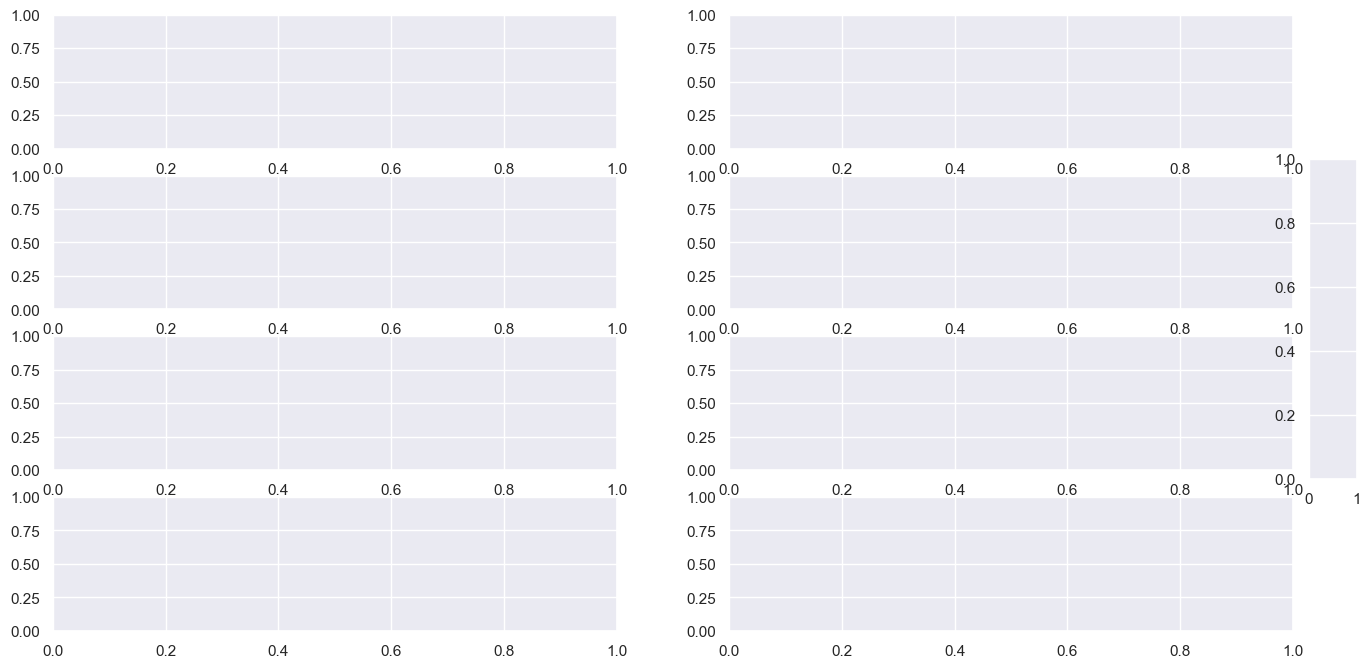

In [136]:
plot_cv_confmat(ys=ys, target_labels=strains.values, accuracies=accuracies, confusion_matrices=confusion_matrices,
				outdir="../../runs/ML/try/NN", name="10(0.5)x1LR0.001,10000epochs.png")